## PARAM

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras import layers
import torch
import math
import pickle
import numpy as np
from sklearn.model_selection import KFold
from tqdm import tqdm 
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

In [2]:
SEQ_LENGTH = 15 
NUM_FEATURE = 1024 
HIDDEN_DIM = 512          # Adjusted for balance between complexity and generalization
BATCH_SIZE = 32            # Moderate batch size for stable training
NUM_HEADS = 8              # Reverted to original for better feature diversity
NUM_ENCODER_LAYERS = 2     # Reduced to avoid overfitting on positive class
DROPOUT = 0.2   
EPOCHS = 25 
K_FOLD=5
NUM_CLASSES = 2
VALIDATION_MODE="independent" # cross or independent

In [3]:
import numpy as np
x_train = np.load("C:/jupyter/Malik/Metal Binding/Additional_ProtTrans/RAG_Class/Rag_CA_train_data.npy", allow_pickle=True)
y_train = np.load("C:/jupyter/Malik/Metal Binding/Additional_ProtTrans/CA_Train_label.npy", allow_pickle=True)
x_test = np.load("C:/jupyter/Malik/Metal Binding/Additional_ProtTrans/RAG_Class/Rag_CA_test_data.npy", allow_pickle=True)
y_test = np.load("C:/jupyter/Malik/Metal Binding/Additional_ProtTrans/CA_Test_label.npy", allow_pickle=True)

In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test .shape)

(504142, 1, 15, 1024)
(504142, 2)
(66854, 1, 15, 1024)
(66854, 2)


In [5]:
# Define the Data Generator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, labels, batch_size):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.data))

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = [self.data[i].squeeze() for i in batch_indexes]  # Squeeze to (15, 1024)
        batch_labels = [self.labels[i] for i in batch_indexes]        # Collect labels without flattening
        return np.array(batch_data), np.array(batch_labels)           # Correct shape for both data and labels


## Model Defination code

In [6]:
import tensorflow as tf
from tensorflow.keras import layers

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_len=SEQ_LENGTH, embed_dim=NUM_FEATURE):
        super(PositionalEncoding, self).__init__()
        self.positional_encoding = self.positional_encoding(max_len, embed_dim)

    def positional_encoding(self, max_len, embed_dim):
        pos = tf.range(max_len, dtype=tf.float32)[:, tf.newaxis]  # (max_len, 1)
        i = tf.range(embed_dim)[tf.newaxis, :]  # (1, embed_dim)
        angle_rates = 1 / tf.pow(10000.0, (2 * tf.cast(i // 2, tf.float32)) / tf.cast(embed_dim, tf.float32))
        angle_rads = pos * angle_rates  # (max_len, embed_dim)

        # Create sine and cosine encodings
        angle_rads_even = tf.sin(angle_rads[:, 0::2])  # Apply to even indices
        angle_rads_odd = tf.cos(angle_rads[:, 1::2])   # Apply to odd indices

        # Create a new tensor to hold the combined results
        angle_rads_combined = tf.zeros_like(angle_rads)  # Initialize tensor of the same shape
        angle_rads_combined = angle_rads_combined.numpy()  # Convert to NumPy for assignment
        angle_rads_combined[:, 0::2] = angle_rads_even.numpy()  # Assign sine values to even indices
        angle_rads_combined[:, 1::2] = angle_rads_odd.numpy()   # Assign cosine values to odd indices

        return tf.convert_to_tensor(angle_rads_combined, dtype=tf.float32)[tf.newaxis, ...]  # Add batch dimension

    def call(self, inputs):
        return inputs + self.positional_encoding[:, :tf.shape(inputs)[1], :]

class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, num_hidden, num_heads):
        super(SelfAttention, self).__init__()
        self.num_heads = num_heads
        self.attention_head_size = num_hidden // num_heads
        self.all_head_size = num_heads * self.attention_head_size

        self.q_dense = layers.Dense(self.all_head_size)
        self.k_dense = layers.Dense(self.all_head_size)
        self.v_dense = layers.Dense(self.all_head_size)
        self.softmax = layers.Softmax(axis=-1)

    def call(self, q, k, v, mask=None):
        q = self.q_dense(q)
        k = self.k_dense(k)
        v = self.v_dense(v)

        q = tf.reshape(q, (-1, tf.shape(q)[1], self.num_heads, self.attention_head_size))
        k = tf.reshape(k, (-1, tf.shape(k)[1], self.num_heads, self.attention_head_size))
        v = tf.reshape(v, (-1, tf.shape(v)[1], self.num_heads, self.attention_head_size))

        q = tf.transpose(q, perm=[0, 2, 1, 3])
        k = tf.transpose(k, perm=[0, 2, 1, 3])
        v = tf.transpose(v, perm=[0, 2, 1, 3])

        attention_scores = tf.matmul(q, k, transpose_b=True) / tf.math.sqrt(float(self.attention_head_size))
        if mask is not None:
            attention_scores += (mask * -1e9)
        attention_probs = self.softmax(attention_scores)
        context_layer = tf.matmul(attention_probs, v)

        context_layer = tf.transpose(context_layer, perm=[0, 2, 1, 3])
        context_layer = tf.reshape(context_layer, (-1, tf.shape(context_layer)[1], self.all_head_size))
        return context_layer

class PositionalAttention(tf.keras.Model):
    def __init__(self, feature_dim, hidden_dim, num_heads, num_classes, dropout_rate):
        super(PositionalAttention, self).__init__()
        self.positional_encoding = PositionalEncoding(max_len=SEQ_LENGTH, embed_dim=feature_dim)
        self.input_block = tf.keras.Sequential([
            layers.LayerNormalization(epsilon=1e-6),
            layers.Dense(hidden_dim, activation='relu'),
            layers.Dropout(dropout_rate)
        ])
        self.attention = SelfAttention(hidden_dim, num_heads)
        self.feed_forward = tf.keras.Sequential([
            layers.Dense(hidden_dim, activation='relu'),
            layers.Dropout(dropout_rate),
            layers.Dense(hidden_dim, activation='relu')
        ])
        self.pooling = layers.GlobalAveragePooling1D()
        self.output_layer = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, mask=None):
        if len(inputs.shape) != 3:
            raise ValueError(f"Expected input to have shape (batch_size, seq_length, num_features), but got {inputs.shape}.")
        
        # Apply positional encoding
        x = self.positional_encoding(inputs)
        x = self.input_block(x)
        x = self.attention(x, x, x, mask)
        x = self.feed_forward(x)
        x = self.pooling(x)
        output = self.output_layer(x)
        return output

In [7]:
# Function to save ROC values
def SAVEROC(fpr, tpr, auc, model_name):
    roc_data = {'fpr': fpr, 'tpr': tpr, 'auc': auc}
    file_path = f"C:/jupyter/Malik/Metal Binding/Code/Additional Test/ROC/{model_name}.pkl"
    with open(file_path, 'wb') as f:
        pickle.dump(roc_data, f)
    print(f"ROC values saved to {file_path}")

def model_test(model, x_test, y_test, model_name):
    print(f'Test data shape: {x_test.shape}')
    
    # Get model predictions and select the positive class probabilities
    pred_test = model.predict(x_test)[:, 1]  # Use the positive class probabilities for binary ROC

    # Compute ROC curve and AUC for binary classification
    fpr, tpr, thresholds = metrics.roc_curve(y_test[:, 1], pred_test)  # y_test[:, 1] gives true positive labels
    AUC = metrics.auc(fpr, tpr)
    
    # Display ROC curve
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=AUC, estimator_name=' PositionalAttentionModel')
    display.plot()
    
    # Save ROC values
    SAVEROC(fpr, tpr, AUC, model_name)
    
    # Calculate G-Mean to find the optimal threshold
    gmeans = np.sqrt(tpr * (1 - fpr))
    ix = np.argmax(gmeans)
    best_threshold = thresholds[ix]
    print(f'Best Threshold={best_threshold}, G-Mean={gmeans[ix]}')
    
    # Apply threshold to get binary predictions
    y_pred = (pred_test >= best_threshold).astype(int)
    
    # Compute confusion matrix and metrics
    TN, FP, FN, TP = metrics.confusion_matrix(y_test[:, 1], y_pred).ravel()  # y_test[:, 1] for true positive class
    Sens = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    Spec = TN / (FP + TN) if (FP + TN) > 0 else 0.0
    Acc = (TP + TN) / (TP + FP + TN + FN)
    Precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    MCC = ((TP * TN) - (FP * FN)) / math.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) \
          if (TP + FP > 0 and TP + FN > 0 and TN + FP > 0 and TN + FN > 0) else 0.0
    F1 = 2 * Precision * Sens / (Precision + Sens) if (Precision + Sens) > 0 else 0.0

    # Print results
    print(f'TP={TP}, FP={FP}, TN={TN}, FN={FN}, Sensitivity={Sens:.4f}, '
          f'Specificity={Spec:.4f}, Accuracy={Acc:.4f}, Precision={Precision:.4f}, '
          f'F1={F1:.4f}, MCC={MCC:.4f}, AUC={AUC:.4f}\n')

    return TP, FP, TN, FN, Sens, Spec, Acc, MCC, AUC, F1, Precision

## Independent Test Set with CA

Shape of y_train: (504142, 2)
Model: "positional_attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 positional_encoding (Positi  multiple                 0         
 onalEncoding)                                                   
                                                                 
 sequential (Sequential)     (32, 15, 512)             526848    
                                                                 
 self_attention (SelfAttenti  multiple                 787968    
 on)                                                             
                                                                 
 sequential_1 (Sequential)   (32, 15, 512)             525312    
                                                                 
 global_average_pooling1d (G  multiple                 0         
 lobalAveragePooling1D)                                          
                

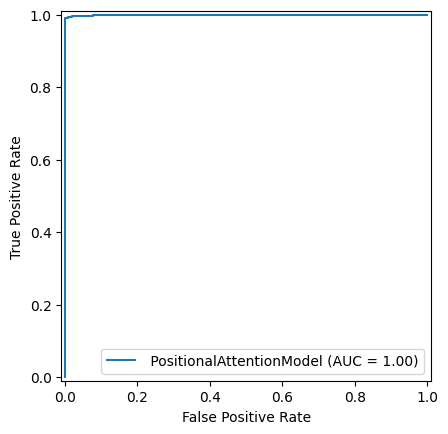

In [8]:
# Training code
if VALIDATION_MODE == "independent":
    # Check the shape of y_train
    print("Shape of y_train:", y_train.shape)

    # Initialize the data generator with the batch size
    generator = DataGenerator(x_train, y_train, batch_size=BATCH_SIZE)

    # Instantiate the AttentionOnlyModel
    model = PositionalAttention(
        feature_dim=NUM_FEATURE,     # Input feature dimension (1024)
        hidden_dim=HIDDEN_DIM,       # Hidden dimension for model
        num_heads=NUM_HEADS,         # Number of attention heads
        num_classes=NUM_CLASSES,     # Number of output classes (2)
        dropout_rate=DROPOUT         # Dropout rate
    )

    # Compile the model with categorical_crossentropy for one-hot encoded labels
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Build the model with the input shape expected by the DataGenerator
    model.build(input_shape=(BATCH_SIZE, SEQ_LENGTH, NUM_FEATURE))
    
    model.summary()

    # Train the model
    history = model.fit(generator, epochs=EPOCHS, verbose=1)

# Test the model
if VALIDATION_MODE == "independent":
    x_test_reshaped = x_test.reshape(-1, 15, 1024)  # Adjust this shape as needed
    print(f"Reshaped Test data shape: {x_test_reshaped.shape}")
    # Run the model test function directly with one-hot encoded y_test
    model_name = "PATN" 
    model_test(model, x_test_reshaped, y_test, model_name)

## Independent Test Set With MG

In [26]:
import numpy as np
x_train = np.load("C:/jupyter/Malik/Metal Binding/Additional_ProtTrans/RAG_Class/Rag_MG_train_data.npy", allow_pickle=True)
y_train = np.load("C:/jupyter/Malik/Metal Binding/Additional_ProtTrans/MG_Train_label.npy", allow_pickle=True)
x_test = np.load("C:/jupyter/Malik/Metal Binding/Additional_ProtTrans/RAG_Class/Rag_MG_test_data.npy", allow_pickle=True)
y_test = np.load("C:/jupyter/Malik/Metal Binding/Additional_ProtTrans/MG_Test_label.npy", allow_pickle=True)

In [27]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test .shape)

(575893, 1, 15, 1024)
(575893, 2)
(88806, 1, 15, 1024)
(88806, 2)


Shape of y_train: (575893, 2)
Model: "positional_attention_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 positional_encoding_4 (Posi  multiple                 0         
 tionalEncoding)                                                 
                                                                 
 sequential_8 (Sequential)   (32, 15, 512)             526848    
                                                                 
 self_attention_4 (SelfAtten  multiple                 787968    
 tion)                                                           
                                                                 
 sequential_9 (Sequential)   (32, 15, 512)             525312    
                                                                 
 global_average_pooling1d_4   multiple                 0         
 (GlobalAveragePooling1D)                                        
              

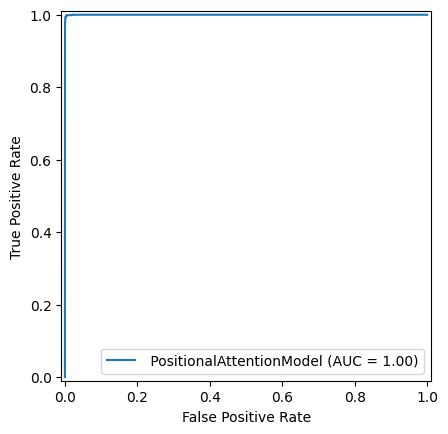

In [28]:
# Training code
if VALIDATION_MODE == "independent":
    # Check the shape of y_train
    print("Shape of y_train:", y_train.shape)

    # Initialize the data generator with the batch size
    generator = DataGenerator(x_train, y_train, batch_size=BATCH_SIZE)

    # Instantiate the AttentionOnlyModel
    model = PositionalAttention(
        feature_dim=NUM_FEATURE,     # Input feature dimension (1024)
        hidden_dim=HIDDEN_DIM,       # Hidden dimension for model
        num_heads=NUM_HEADS,         # Number of attention heads
        num_classes=NUM_CLASSES,     # Number of output classes (2)
        dropout_rate=DROPOUT         # Dropout rate
    )

    # Compile the model with categorical_crossentropy for one-hot encoded labels
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Build the model with the input shape expected by the DataGenerator
    model.build(input_shape=(BATCH_SIZE, SEQ_LENGTH, NUM_FEATURE))
    
    model.summary()

    # Train the model
    history = model.fit(generator, epochs=EPOCHS, verbose=1)

# Test the model
if VALIDATION_MODE == "independent":
    x_test_reshaped = x_test.reshape(-1, 15, 1024)  # Adjust this shape as needed
    print(f"Reshaped Test data shape: {x_test_reshaped.shape}")
    # Run the model test function directly with one-hot encoded y_test
    model_name = "PATN_MG" 
    model_test(model, x_test_reshaped, y_test, model_name)

## Independent Test Set With MN

In [16]:
import numpy as np
x_train = np.load("C:/jupyter/Malik/Metal Binding/Additional_ProtTrans/RAG_Class/Rag_MN_train_data.npy", allow_pickle=True)
y_train = np.load("C:/jupyter/Malik/Metal Binding/Additional_ProtTrans/MN_Train_label.npy", allow_pickle=True)
x_test = np.load("C:/jupyter/Malik/Metal Binding/Additional_ProtTrans/RAG_Class/Rag_MN_test_data.npy", allow_pickle=True)
y_test = np.load("C:/jupyter/Malik/Metal Binding/Additional_ProtTrans/MN_Test_label.npy", allow_pickle=True)

In [17]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test .shape)

(181699, 1, 15, 1024)
(181699, 2)
(20419, 1, 15, 1024)
(20419, 2)


Shape of y_train: (181699, 2)
Model: "positional_attention_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 positional_encoding_2 (Posi  multiple                 0         
 tionalEncoding)                                                 
                                                                 
 sequential_4 (Sequential)   (32, 15, 512)             526848    
                                                                 
 self_attention_2 (SelfAtten  multiple                 787968    
 tion)                                                           
                                                                 
 sequential_5 (Sequential)   (32, 15, 512)             525312    
                                                                 
 global_average_pooling1d_2   multiple                 0         
 (GlobalAveragePooling1D)                                        
              

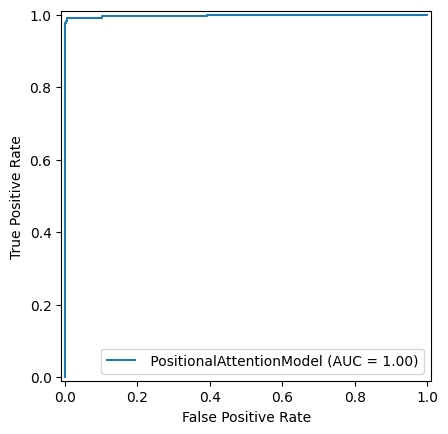

In [18]:
# Training code
if VALIDATION_MODE == "independent":
    # Check the shape of y_train
    print("Shape of y_train:", y_train.shape)

    # Initialize the data generator with the batch size
    generator = DataGenerator(x_train, y_train, batch_size=BATCH_SIZE)

    # Instantiate the AttentionOnlyModel
    model = PositionalAttention(
        feature_dim=NUM_FEATURE,     # Input feature dimension (1024)
        hidden_dim=HIDDEN_DIM,       # Hidden dimension for model
        num_heads=NUM_HEADS,         # Number of attention heads
        num_classes=NUM_CLASSES,     # Number of output classes (2)
        dropout_rate=DROPOUT         # Dropout rate
    )

    # Compile the model with categorical_crossentropy for one-hot encoded labels
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Build the model with the input shape expected by the DataGenerator
    model.build(input_shape=(BATCH_SIZE, SEQ_LENGTH, NUM_FEATURE))
    
    model.summary()

    # Train the model
    history = model.fit(generator, epochs=EPOCHS, verbose=1)

# Test the model
if VALIDATION_MODE == "independent":
    x_test_reshaped = x_test.reshape(-1, 15, 1024)  # Adjust this shape as needed
    print(f"Reshaped Test data shape: {x_test_reshaped.shape}")
    # Run the model test function directly with one-hot encoded y_test
    model_name = "PATN_MN" 
    model_test(model, x_test_reshaped, y_test, model_name)

## Independent Test Set With ZN

In [23]:
import numpy as np
x_train = np.load("C:/jupyter/Malik/Metal Binding/Additional_ProtTrans/RAG_Class/Rag_ZN_train_data.npy", allow_pickle=True)
y_train = np.load("C:/jupyter/Malik/Metal Binding/Additional_ProtTrans/ZN_Train_label.npy", allow_pickle=True)
x_test = np.load("C:/jupyter/Malik/Metal Binding/Additional_ProtTrans/RAG_Class/Rag_ZN_test_data.npy", allow_pickle=True)
y_test = np.load("C:/jupyter/Malik/Metal Binding/Additional_ProtTrans/ZN_Test_label.npy", allow_pickle=True)

In [24]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test .shape)

(474915, 1, 15, 1024)
(474915, 2)
(56020, 1, 15, 1024)
(56020, 2)


Shape of y_train: (474915, 2)
Model: "positional_attention_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 positional_encoding_3 (Posi  multiple                 0         
 tionalEncoding)                                                 
                                                                 
 sequential_6 (Sequential)   (32, 15, 512)             526848    
                                                                 
 self_attention_3 (SelfAtten  multiple                 787968    
 tion)                                                           
                                                                 
 sequential_7 (Sequential)   (32, 15, 512)             525312    
                                                                 
 global_average_pooling1d_3   multiple                 0         
 (GlobalAveragePooling1D)                                        
              

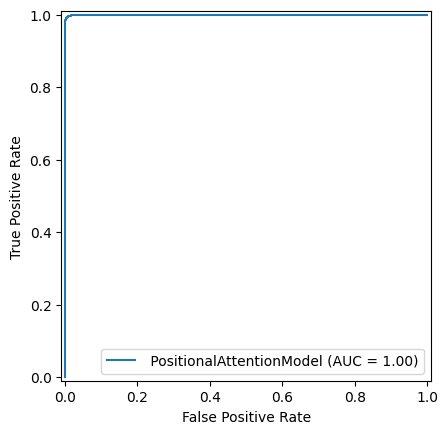

In [25]:
# Training code
if VALIDATION_MODE == "independent":
    # Check the shape of y_train
    print("Shape of y_train:", y_train.shape)

    # Initialize the data generator with the batch size
    generator = DataGenerator(x_train, y_train, batch_size=BATCH_SIZE)

    # Instantiate the AttentionOnlyModel
    model = PositionalAttention(
        feature_dim=NUM_FEATURE,     # Input feature dimension (1024)
        hidden_dim=HIDDEN_DIM,       # Hidden dimension for model
        num_heads=NUM_HEADS,         # Number of attention heads
        num_classes=NUM_CLASSES,     # Number of output classes (2)
        dropout_rate=DROPOUT         # Dropout rate
    )

    # Compile the model with categorical_crossentropy for one-hot encoded labels
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Build the model with the input shape expected by the DataGenerator
    model.build(input_shape=(BATCH_SIZE, SEQ_LENGTH, NUM_FEATURE))
    
    model.summary()

    # Train the model
    history = model.fit(generator, epochs=EPOCHS, verbose=1)

# Test the model
if VALIDATION_MODE == "independent":
    x_test_reshaped = x_test.reshape(-1, 15, 1024)  # Adjust this shape as needed
    print(f"Reshaped Test data shape: {x_test_reshaped.shape}")
    # Run the model test function directly with one-hot encoded y_test
    model_name = "PATN_ZN" 
    model_test(model, x_test_reshaped, y_test, model_name)